In [1]:
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

#**BUILDING TRACKS NAME DATSET**

In [2]:
pip install spotipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.3/240.3 kB 7.2 MB/s eta 0:00:00


In [3]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

client_id = 'XXXXXXXXXXXXXXXXX'
client_secret = 'XXXXXXXXXXXXXXXXX'

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)


##Data collection from spotify playlist (1970-2020)

In [ ]:
playlist_id = '2U5naKBJ5DN3oOPbuRiTem'

offset = 0
spotify_tracks = np.array([])

while True:
    results = sp.playlist_tracks(playlist_id, offset=offset)

    if len(results['items']) == 0:
        break

    for item in results['items']:
        track = item['track']
        track_name = track['name']
        spotify_tracks = np.append(spotify_tracks, track_name)

    offset += len(results['items'])

print(len(spotify_tracks))
print(spotify_tracks[:5])

990
['Kya Karoon?' 'Iktara' 'Ishq Bulaava' 'Darasal (From "Raabta")'
 'Saudebazi (Encore) [From "Aakrosh"]']


##Data collection from new spotify playlist (2021, 2022, 2023)

In [ ]:
latest_spotify_tracks = np.array([])

playlist_id_2021 = "37i9dQZF1DX7BXvxNJkwzB"
playlist_id_2022 = "37i9dQZF1DWXRgBZj2DeRk"
playlist_id_2023 = '1qk7sHSUKBuKeDaMeTQqMY'
playlist_id_new = "37i9dQZF1DX0XUfTFmNBRM"

playlists = [playlist_id_2021, playlist_id_2022, playlist_id_2023, playlist_id_new]

for link in playlists:

  offset = 0
  while True:
      results = sp.playlist_tracks(link, offset=offset)

      if len(results['items']) == 0:
          break

      for item in results['items']:
          track = item['track']
          track_name = track['name']
          latest_spotify_tracks = np.append(latest_spotify_tracks, track_name)

      offset += len(results['items'])

print(len(latest_spotify_tracks))
print(latest_spotify_tracks[:5])

289
['Raataan Lambiyan' 'Ranjha' 'Lut Gaye' 'Agar Tum Saath Ho'
 'Tu Aake Dekhle']


##Data collection from external datset (Kaggle)

In [5]:
df = pd.read_csv("/content/songs_name_data.csv", encoding='latin-1')
external_tracks = df["Song-Name"].values

##Combining all tracks_Array

In [ ]:
all_tracks = np.concatenate((spotify_tracks, latest_spotify_tracks, external_tracks))
new_all_tracks = np.unique(all_tracks)

len(all_tracks), len(new_all_tracks)

In [ ]:
songs_df = pd.DataFrame(new_all_tracks)
songs_df

In [ ]:
songs_df.to_csv("songs_name_data.csv", index=False)

#**BUILDING TRACKS AUDIO FEATURE DATASET**

In [ ]:
df = pd.read_csv("/content/songs_name_data.csv")
df

,0
0,20-20
1,440 Volt
2,A B C D E F G H
3,A Flying Jatt
4,ABCD
...,...
3119,Apna Bana Le
3120,Teri Meri Kahani
3121,Dildara
3122,Main Rahoon Ya Na Rahoon


In [ ]:
df.duplicated().sum()

0

In [ ]:
df.isna().sum()

0    0
dtype: int64

In [ ]:
tracks_array = df["0"].values
tracks_array

array(['20-20', '440 Volt', 'A B C D E F G H', ..., 'Dildara',
       'Main Rahoon Ya Na Rahoon', 'Dil Na Jaaneya'], dtype=object)

In [ ]:


tracks_detail = np.empty(22)

progress = 0
for track_name in tracks_array:
    results = sp.search(q=track_name, type='track', limit=1)
    
    progress+=1
    if progress%300==0:
        print(progress//30, "% Completed")
    

    if len(results['tracks']['items']) > 0:
        track = results['tracks']['items'][0]

        track_name = track['name']
        artist_name = track['artists'][0]['name']
        album_name = track['album']['name']
        track_id = track['id']
        preview_url = track['preview_url']
        popularity = track['popularity']
        release_date = track['album']['release_date']
        song_url = track['external_urls']['spotify']

        artist_id = track['artists'][0]['id']
        artist = sp.artist(artist_id)
        genres = artist['genres']

    
        audio_features = sp.audio_features([track_id])[0]

        def check_na(feature):
          try:
            feature = audio_features[f"{feature}"]
          except:
            feature = "NA"
          
          return feature
        
        acousticness = check_na("acousticness")
        danceability = check_na("danceability")
        duration_ms = check_na('duration_ms')
        energy = check_na('energy')
        instrumentalness = check_na('instrumentalness')
        key = check_na('key')
        liveness = check_na('liveness')
        loudness = check_na('loudness')
        mode = check_na('mode')
        speechiness = check_na('speechiness')
        tempo = check_na('tempo')
        time_signature = check_na('time_signature')
        valence = check_na('valence')
        
        temp = np.array([track_name, artist_name, album_name, track_id, preview_url, popularity, release_date, song_url, genres, acousticness, danceability, 
                        duration_ms, energy, instrumentalness, key, liveness, loudness, mode, speechiness, tempo, time_signature,
                        valence])
        
        tracks_detail = np.vstack((tracks_detail, temp))
    
    else:
        print("No matching tracks found.")


<ipython-input-24-c8cded204d1a>:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  temp = np.array([track_name, artist_name, album_name, track_id, preview_url, popularity, release_date, song_url, genres, acousticness, danceability,


10 % Completed
20 % Completed
30 % Completed
40 % Completed
50 % Completed
60 % Completed
70 % Completed
80 % Completed
90 % Completed
100 % Completed


In [ ]:
df = pd.DataFrame(tracks_detail)
df.columns = ["track_name", "artist_name", "album_name", "track_id", "preview_url", "popularity", "release_date", "song_url", "genres", "acousticness", "danceability", 
                        "duration_ms", "energy", "instrumentalness", "key", "liveness", "loudness", "mode", "speechiness", "tempo", "time_signature",
                        "valence"]
df

,track_name,artist_name,album_name,track_id,preview_url,popularity,release_date,song_url,genres,acousticness,...,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20/20,Lil Tjay,20/20,4Hqh0dS4x07zuRw6eBTO7p,https://p.scdn.co/mp3-preview/72dc8c9168171e59...,64,2020-01-01,https://open.spotify.com/track/4Hqh0dS4x07zuRw...,"[brooklyn drill, melodic rap, nyc rap, rap]",0.557,...,0.336,0,4,0.0933,-12.779,1,0.239,100.044,4,0.536
2,440 Volt,Vishal-Shekhar,Sultan,4K1zKRQr4GzysIYelA2XUw,https://p.scdn.co/mp3-preview/b5aa07749f0e0e9c...,49,2016-05-31,https://open.spotify.com/track/4K1zKRQr4GzysIY...,"[desi pop, filmi, modern bollywood]",0.257,...,0.717,0,6,0.0681,-7.939,1,0.0686,162.084,3,0.771
3,A B C D E F G H I Love You,Hariharan,Hum Saath - Saath Hain (Original Motion Pictur...,6bqIRqzCCAv0wocLlsj2xQ,https://p.scdn.co/mp3-preview/26c4ed0173d52ef2...,44,1999,https://open.spotify.com/track/6bqIRqzCCAv0woc...,"[filmi, ghazal]",0.455,...,0.726,0.000184,0,0.0819,-10.335,0,0.0521,116.071,4,0.856
4,FF4,Flying Lotus,Flamagra,39nSL4qbk0rsGNSVJb5TWK,https://p.scdn.co/mp3-preview/f4f91f59e1fcfc49...,54,2019-05-24,https://open.spotify.com/track/39nSL4qbk0rsGNS...,"[afrofuturism, alternative hip hop, electronic...",0.43,...,0.184,0.937,6,0.117,-7.69,1,0.0681,81.244,4,0.486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3120,Apna Bana Le (LoFi),Arpita Majumder,Apna Bana Le (LoFi),2XqlZgTxuSCQXbl4NLoELQ,https://p.scdn.co/mp3-preview/c3dcbc1c0edd31b1...,60,2023-03-12,https://open.spotify.com/track/2XqlZgTxuSCQXbl...,[],0.886,...,0.341,0.000069,11,0.233,-15.087,0,0.0994,90.017,4,0.629
3121,Teri Meri Kahani,Ananya Birla,Teri Meri Kahani,5ftyuvT3jQotZvo6sJnyce,https://p.scdn.co/mp3-preview/85427119908ab05e...,49,2022-07-29,https://open.spotify.com/track/5ftyuvT3jQotZvo...,[desi pop],0.625,...,0.623,0.00005,4,0.302,-7.759,1,0.031,95.985,4,0.407
3122,Dildara,Azaan Sami Khan,Dildara,26Hwwgo7lQGunLHFe5CCc5,https://p.scdn.co/mp3-preview/1ae0ec1429eb4a22...,43,2023-03-04,https://open.spotify.com/track/26Hwwgo7lQGunLH...,[pakistani pop],0.514,...,0.487,0.0305,7,0.122,-11.884,0,0.0706,86.097,4,0.318
3123,Main Rahoon Ya Na Rahoon,Amaal Mallik,Main Rahoon Ya Na Rahoon,6f3ANRNQ8nCiPZ6VqXqq93,https://p.scdn.co/mp3-preview/94089142acb23fa5...,74,2015-11-24,https://open.spotify.com/track/6f3ANRNQ8nCiPZ6...,"[desi pop, filmi, modern bollywood]",0.718,...,0.488,0.000118,6,0.126,-8.059,1,0.0284,136.025,3,0.301


In [ ]:
df.to_csv('tracks_detail_dataset.csv', index=False)

#**Data Cleaning**

In [ ]:
df = pd.read_csv("/content/tracks_detail_dataset.csv")
df

,track_name,artist_name,album_name,track_id,preview_url,popularity,release_date,song_url,genres,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,6.9322811854781e-310,6.93228108665073e-310,6.9322811854117e-310,6.93228108666654e-310,6.9322817775221e-310,6.932342e-310,6.93228175944324e-310,6.93228116396054e-310,6.93228198351743e-310,6.932282e-310,6.932282e-310,6.932282e-310,6.932282e-310,6.932282e-310,6.932342e-310,6.932282e-310,6.932282e-310,6.932342e-310,6.932282e-310,6.932282e-310,6.932342e-310,6.932282e-310
1,20/20,Lil Tjay,20/20,4Hqh0dS4x07zuRw6eBTO7p,https://p.scdn.co/mp3-preview/72dc8c9168171e59...,6.400000e+01,2020-01-01,https://open.spotify.com/track/4Hqh0dS4x07zuRw...,"['brooklyn drill', 'melodic rap', 'nyc rap', '...",5.570000e-01,8.860000e-01,2.304480e+05,3.360000e-01,0.000000e+00,4.000000e+00,9.330000e-02,-1.277900e+01,1.000000e+00,2.390000e-01,1.000440e+02,4.000000e+00,5.360000e-01
2,440 Volt,Vishal-Shekhar,Sultan,4K1zKRQr4GzysIYelA2XUw,https://p.scdn.co/mp3-preview/b5aa07749f0e0e9c...,4.900000e+01,2016-05-31,https://open.spotify.com/track/4K1zKRQr4GzysIY...,"['desi pop', 'filmi', 'modern bollywood']",2.570000e-01,6.950000e-01,2.681210e+05,7.170000e-01,0.000000e+00,6.000000e+00,6.810000e-02,-7.939000e+00,1.000000e+00,6.860000e-02,1.620840e+02,3.000000e+00,7.710000e-01
3,A B C D E F G H I Love You,Hariharan,Hum Saath - Saath Hain (Original Motion Pictur...,6bqIRqzCCAv0wocLlsj2xQ,https://p.scdn.co/mp3-preview/26c4ed0173d52ef2...,4.400000e+01,1999,https://open.spotify.com/track/6bqIRqzCCAv0woc...,"['filmi', 'ghazal']",4.550000e-01,8.040000e-01,2.724830e+05,7.260000e-01,1.840000e-04,0.000000e+00,8.190000e-02,-1.033500e+01,0.000000e+00,5.210000e-02,1.160710e+02,4.000000e+00,8.560000e-01
4,FF4,Flying Lotus,Flamagra,39nSL4qbk0rsGNSVJb5TWK,https://p.scdn.co/mp3-preview/f4f91f59e1fcfc49...,5.400000e+01,2019-05-24,https://open.spotify.com/track/39nSL4qbk0rsGNS...,"['afrofuturism', 'alternative hip hop', 'elect...",4.300000e-01,6.070000e-01,7.152000e+04,1.840000e-01,9.370000e-01,6.000000e+00,1.170000e-01,-7.690000e+00,1.000000e+00,6.810000e-02,8.124400e+01,4.000000e+00,4.860000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3120,Apna Bana Le (LoFi),Arpita Majumder,Apna Bana Le (LoFi),2XqlZgTxuSCQXbl4NLoELQ,https://p.scdn.co/mp3-preview/c3dcbc1c0edd31b1...,6.000000e+01,2023-03-12,https://open.spotify.com/track/2XqlZgTxuSCQXbl...,[],8.860000e-01,6.700000e-01,5.335600e+04,3.410000e-01,6.910000e-05,1.100000e+01,2.330000e-01,-1.508700e+01,0.000000e+00,9.940000e-02,9.001700e+01,4.000000e+00,6.290000e-01
3121,Teri Meri Kahani,Ananya Birla,Teri Meri Kahani,5ftyuvT3jQotZvo6sJnyce,https://p.scdn.co/mp3-preview/85427119908ab05e...,4.900000e+01,2022-07-29,https://open.spotify.com/track/5ftyuvT3jQotZvo...,['desi pop'],6.250000e-01,7.210000e-01,1.551560e+05,6.230000e-01,5.040000e-05,4.000000e+00,3.020000e-01,-7.759000e+00,1.000000e+00,3.100000e-02,9.598500e+01,4.000000e+00,4.070000e-01
3122,Dildara,Azaan Sami Khan,Dildara,26Hwwgo7lQGunLHFe5CCc5,https://p.scdn.co/mp3-preview/1ae0ec1429eb4a22...,4.300000e+01,2023-03-04,https://open.spotify.com/track/26Hwwgo7lQGunLH...,['pakistani pop'],5.140000e-01,5.470000e-01,2.734880e+05,4.870000e-01,3.050000e-02,7.000000e+00,1.220000e-01,-1.188400e+01,0.000000e+00,7.060000e-02,8.609700e+01,4.000000e+00,3.180000e-01
3123,Main Rahoon Ya Na Rahoon,Amaal Mallik,Main Rahoon Ya Na Rahoon,6f3ANRNQ8nCiPZ6VqXqq93,https://p.scdn.co/mp3-preview/94089142acb23fa5...,7.400000e+01,2015-11-24,https://open.spotify.com/track/6f3ANRNQ8nCiPZ6...,"['desi pop', 'filmi', 'modern bollywood']",7.180000e-01,5.500000e-01,3.094580e+05,4.880000e-01,1.180000e-04,6.000000e+00,1.260000e-01,-8.059000e+00,1.000000e+00,2.840000e-02,1.360250e+02,3.000000e+00,3.010000e-01


In [ ]:
df.drop(0, inplace=True)
df.drop(1, inplace=True)
df.head()

,track_name,artist_name,album_name,track_id,preview_url,popularity,release_date,song_url,genres,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
2,440 Volt,Vishal-Shekhar,Sultan,4K1zKRQr4GzysIYelA2XUw,https://p.scdn.co/mp3-preview/b5aa07749f0e0e9c...,49.0,2016-05-31,https://open.spotify.com/track/4K1zKRQr4GzysIY...,"['desi pop', 'filmi', 'modern bollywood']",0.2570,0.695,268121.0,0.717,0.000000,6.0,0.0681,-7.939,1.0,0.0686,162.084,3.0,0.771
3,A B C D E F G H I Love You,Hariharan,Hum Saath - Saath Hain (Original Motion Pictur...,6bqIRqzCCAv0wocLlsj2xQ,https://p.scdn.co/mp3-preview/26c4ed0173d52ef2...,44.0,1999,https://open.spotify.com/track/6bqIRqzCCAv0woc...,"['filmi', 'ghazal']",0.4550,0.804,272483.0,0.726,0.000184,0.0,0.0819,-10.335,0.0,0.0521,116.071,4.0,0.856
4,FF4,Flying Lotus,Flamagra,39nSL4qbk0rsGNSVJb5TWK,https://p.scdn.co/mp3-preview/f4f91f59e1fcfc49...,54.0,2019-05-24,https://open.spotify.com/track/39nSL4qbk0rsGNS...,"['afrofuturism', 'alternative hip hop', 'elect...",0.4300,0.607,71520.0,0.184,0.937000,6.0,0.1170,-7.690,1.0,0.0681,81.244,4.0,0.486
5,Abcdario,Eden Muñoz,Abcdario,0qCPD6ilr9nXkI4KVZgcns,https://p.scdn.co/mp3-preview/cffa97f5cc84817b...,88.0,2023-05-13,https://open.spotify.com/track/0qCPD6ilr9nXkI4...,"['corrido', 'nueva musica mexicana', 'sierreno']",0.7830,0.703,220650.0,0.429,0.000001,8.0,0.1130,-9.076,1.0,0.0308,129.034,4.0,0.416
6,Abcd -Yaariyan,Pritam,Yaariyan,6n92iq9Kni83H6IroZ3RJJ,https://p.scdn.co/mp3-preview/e6d0d62a7d58dfde...,49.0,2013-12-09,https://open.spotify.com/track/6n92iq9Kni83H6I...,"['desi pop', 'filmi', 'indian instrumental', '...",0.0217,0.699,205513.0,0.815,0.000000,0.0,0.0466,-4.282,1.0,0.0584,127.985,4.0,0.737


In [ ]:
df.isna().sum()

track_name          0
artist_name         0
album_name          0
track_id            0
preview_url         1
popularity          0
release_date        0
song_url            0
genres              0
acousticness        2
danceability        2
duration_ms         2
energy              2
instrumentalness    2
key                 2
liveness            2
loudness            2
mode                2
speechiness         2
tempo               2
time_signature      2
valence             2
dtype: int64

In [ ]:
df[df.isna().any(axis=1)]

,track_name,artist_name,album_name,track_id,preview_url,popularity,release_date,song_url,genres,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
567,Everyone's Confused,The Undercover Dream Lovers,It's All in Your Head,5jkbbD4MKFJMvX6QloaLRy,https://p.scdn.co/mp3-preview/6e05c08dde5851d1...,13.0,2020-02-27,https://open.spotify.com/track/5jkbbD4MKFJMvX6...,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1284,Jeena Jeena,utku INC,Jeena Jeena,3XesWXNatUvQbel6XKwokn,NaN,50.0,1929-12-31,https://open.spotify.com/track/3XesWXNatUvQbel...,['speed up turkce'],0.78,0.685,228972.0,0.333,0.0,5.0,0.125,-8.837,1.0,0.0277,104.997,4.0,0.543
1472,Tu Kaafi Hai,Aisha Kamath,Tu Kaafi Hai,5fLS5ArHuJeTNaNVEwK6Mm,https://p.scdn.co/mp3-preview/2b67b8a04a3c75dc...,1.0,2022-08-24,https://open.spotify.com/track/5fLS5ArHuJeTNaN...,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.dropna(inplace=True)

In [ ]:
df.isna().sum()

track_name          0
artist_name         0
album_name          0
track_id            0
preview_url         0
popularity          0
release_date        0
song_url            0
genres              0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64

In [ ]:
df.duplicated(subset='track_id').sum()

261

In [ ]:
df = df.drop_duplicates(subset='track_id', keep='first')
df.duplicated(subset='track_id').sum()

0

In [ ]:
df.duplicated(subset='track_name').sum()

17

In [ ]:
df = df.drop_duplicates(subset='track_name', keep='first')
df.duplicated(subset='track_name').sum()

0

In [ ]:
df.sample(5)

,track_name,artist_name,album_name,track_id,preview_url,popularity,release_date,song_url,genres,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
32,Aai Paapi,Neeraj Shridhar,Kismat Konnection (Original Motion Picture Sou...,7Bw56mGeOVbBBWBSLg356s,https://p.scdn.co/mp3-preview/f660d00a18af8929...,56.0,2008-07-18,https://open.spotify.com/track/7Bw56mGeOVbBBWB...,"['desi pop', 'filmi', 'modern bollywood']",0.1210,0.905,260053.0,0.952,0.001820,9.0,0.0441,-6.429,1.0,0.0566,109.972,4.0,0.797
2757,"Tharki Chokro (From ""Pk"")",Swaroop Khan,Ajay Atul Hit Songs,3MTvJffwNBPwAAHB1C4Lmh,https://p.scdn.co/mp3-preview/96befb1f4f510462...,10.0,2023-05-25,https://open.spotify.com/track/3MTvJffwNBPwAAH...,[],0.2120,0.693,295776.0,0.899,0.000545,0.0,0.1120,-5.817,1.0,0.0638,135.005,4.0,0.830
1731,Maiya Yashoda,Anuradha Paudwal,Hum Saath - Saath Hain (Original Motion Pictur...,4TPQHwC2bZBLZ5PdzdqMeL,https://p.scdn.co/mp3-preview/3aa23b1b3560fbb6...,46.0,1999,https://open.spotify.com/track/4TPQHwC2bZBLZ5P...,"['bhajan', 'filmi', 'ghazal', 'hare krishna']",0.6110,0.434,379324.0,0.501,0.000026,0.0,0.2150,-10.883,1.0,0.0941,175.937,3.0,0.825
2573,"Soniye Je (From ""Gumraah"")",Vishal Mishra,"Soniye Je (From ""Gumraah"")",2yRcylnbhH6FT5vAcLHwIB,https://p.scdn.co/mp3-preview/b1288072c8e98429...,61.0,2023-03-14,https://open.spotify.com/track/2yRcylnbhH6FT5v...,"['desi pop', 'filmi', 'modern bollywood']",0.0183,0.833,160485.0,0.679,0.000000,1.0,0.0777,-4.014,1.0,0.1540,109.969,4.0,0.797
3054,Yeh Hum Aa Gaye Hain Kahaan,Madan Mohan,Veer - Zaara,7sSYkaAXRgnzoQYrGgrvlX,https://p.scdn.co/mp3-preview/04c0e93be06cfb8d...,55.0,2004-09-18,https://open.spotify.com/track/7sSYkaAXRgnzoQY...,"['classic bollywood', 'filmi', 'indian instrum...",0.3470,0.480,343066.0,0.753,0.000335,5.0,0.3150,-7.330,0.0,0.0454,90.027,4.0,0.462


In [ ]:
df['track_name'] = df['track_name'].str.replace(r'\s+\(.*\)', '')
df.loc[2080].to_frame().T

<ipython-input-133-d1665d360849>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['track_name'] = df['track_name'].str.replace(r'\s+\(.*\)', '')


,track_name,artist_name,album_name,track_id,preview_url,popularity,release_date,song_url,genres,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
2080,O Mere Dil Ke Chain,Kishore Kumar,Krazy Kishore,71hanKncfyBt0Yi66LRUYm,https://p.scdn.co/mp3-preview/ab8fb182f661295f...,48.0,2018-04-24,https://open.spotify.com/track/71hanKncfyBt0Yi...,"['classic bollywood', 'filmi']",0.658,0.434,273357.0,0.551,0.0,9.0,0.0749,-8.396,0.0,0.0307,110.23,4.0,0.582


In [ ]:
df[1555:1560]

,track_name,artist_name,album_name,track_id,preview_url,popularity,release_date,song_url,genres,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
1692,Main Hoon Hero Tera,Armaan Malik,Hero,7jDKrOCSA26DfGy3ZAVVoI,https://p.scdn.co/mp3-preview/296fa60b20418d28...,54.0,2015-08-14,https://open.spotify.com/track/7jDKrOCSA26DfGy...,"['desi pop', 'filmi', 'modern bollywood']",0.103,0.602,284201.0,0.622,0.000000,7.0,0.138,-5.608,0.0,0.0293,110.018,4.0,0.226
1695,Main Hoon Prem Rogi,Suresh Wadkar,Prem Rog (Original Motion Picture Soundtrack),3fwMxmjD584WZhpFrAMkRG,https://p.scdn.co/mp3-preview/928e833420f772d0...,15.0,1982-12-01,https://open.spotify.com/track/3fwMxmjD584WZhp...,"['bhajan', 'classic bollywood', 'filmi', 'garh...",0.734,0.354,478240.0,0.820,0.000022,4.0,0.142,-8.891,0.0,0.0971,156.571,3.0,0.809
1696,Main Hoon Roop Ki Rani,Kavita Krishnamurthy,Roop Ki Rani Choron Ka Raja (Original Motion P...,37WWFIrA6gK9btyEt1mkEZ,https://p.scdn.co/mp3-preview/8a7b8664ed981276...,1.0,1993-04-16,https://open.spotify.com/track/37WWFIrA6gK9bty...,['filmi'],0.949,0.325,529394.0,0.489,0.092100,10.0,0.130,-13.632,1.0,0.1350,66.853,4.0,0.555
1697,Main Hoon Na Tere Saath,Amaal Mallik,"Main Hoon Na Tere Saath (From ""Saina"")",0UyOmUko2F1eyBFQgFc6Fp,https://p.scdn.co/mp3-preview/b542f3d5ac9080e8...,47.0,2021-03-18,https://open.spotify.com/track/0UyOmUko2F1eyBF...,"['desi pop', 'filmi', 'modern bollywood']",0.749,0.509,328090.0,0.478,0.000000,9.0,0.114,-9.990,0.0,0.0327,131.903,4.0,0.313
1698,Main Jahaan Rahoon - Instrumental,Naveen Kumar,Melodies of Love,2nmfekXkcyd0w92dY2Lrwp,https://p.scdn.co/mp3-preview/847c6cae2cb0e811...,36.0,2011-03-28,https://open.spotify.com/track/2nmfekXkcyd0w92...,['indian instrumental'],0.591,0.704,292040.0,0.671,0.295000,5.0,0.136,-7.848,1.0,0.0297,104.041,4.0,0.690


In [ ]:
df["album_name"] = df["album_name"].str.replace("(Original Motion Picture Soundtrack)", "")

<ipython-input-135-504371924308>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df["album_name"] = df["album_name"].str.replace("(Original Motion Picture Soundtrack)", "")


In [ ]:
df["album_name"] = df["album_name"].str.replace(r'\(\)', '')

<ipython-input-136-63141ae6e483>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df["album_name"] = df["album_name"].str.replace(r'\(\)', '')


In [ ]:
df["album_name"] = df["album_name"].str.split("From").str[-1]

temp = np.array([])

for i in df["album_name"]:
  if i[-2:] == '")':
    temp = np.append(temp, i[:-1])
  else:
    temp = np.append(temp, i)

df["album_name"] = temp

In [ ]:
df[1555:1560]

,track_name,artist_name,album_name,track_id,preview_url,popularity,release_date,song_url,genres,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
1692,Main Hoon Hero Tera,Armaan Malik,Hero,7jDKrOCSA26DfGy3ZAVVoI,https://p.scdn.co/mp3-preview/296fa60b20418d28...,54.0,2015-08-14,https://open.spotify.com/track/7jDKrOCSA26DfGy...,"['desi pop', 'filmi', 'modern bollywood']",0.103,0.602,284201.0,0.622,0.000000,7.0,0.138,-5.608,0.0,0.0293,110.018,4.0,0.226
1695,Main Hoon Prem Rogi,Suresh Wadkar,Prem Rog,3fwMxmjD584WZhpFrAMkRG,https://p.scdn.co/mp3-preview/928e833420f772d0...,15.0,1982-12-01,https://open.spotify.com/track/3fwMxmjD584WZhp...,"['bhajan', 'classic bollywood', 'filmi', 'garh...",0.734,0.354,478240.0,0.820,0.000022,4.0,0.142,-8.891,0.0,0.0971,156.571,3.0,0.809
1696,Main Hoon Roop Ki Rani,Kavita Krishnamurthy,Roop Ki Rani Choron Ka Raja,37WWFIrA6gK9btyEt1mkEZ,https://p.scdn.co/mp3-preview/8a7b8664ed981276...,1.0,1993-04-16,https://open.spotify.com/track/37WWFIrA6gK9bty...,['filmi'],0.949,0.325,529394.0,0.489,0.092100,10.0,0.130,-13.632,1.0,0.1350,66.853,4.0,0.555
1697,Main Hoon Na Tere Saath,Amaal Mallik,"""Saina""",0UyOmUko2F1eyBFQgFc6Fp,https://p.scdn.co/mp3-preview/b542f3d5ac9080e8...,47.0,2021-03-18,https://open.spotify.com/track/0UyOmUko2F1eyBF...,"['desi pop', 'filmi', 'modern bollywood']",0.749,0.509,328090.0,0.478,0.000000,9.0,0.114,-9.990,0.0,0.0327,131.903,4.0,0.313
1698,Main Jahaan Rahoon - Instrumental,Naveen Kumar,Melodies of Love,2nmfekXkcyd0w92dY2Lrwp,https://p.scdn.co/mp3-preview/847c6cae2cb0e811...,36.0,2011-03-28,https://open.spotify.com/track/2nmfekXkcyd0w92...,['indian instrumental'],0.591,0.704,292040.0,0.671,0.295000,5.0,0.136,-7.848,1.0,0.0297,104.041,4.0,0.690


In [ ]:
df = df.drop_duplicates(subset='track_name', keep='first')
df.duplicated(subset='track_name').sum()

0

#**EXPLORATORY DATA ANALYSIS**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2731 entries, 2 to 3123
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_name        2731 non-null   object 
 1   artist_name       2731 non-null   object 
 2   album_name        2731 non-null   object 
 3   track_id          2731 non-null   object 
 4   preview_url       2731 non-null   object 
 5   popularity        2731 non-null   float64
 6   release_date      2731 non-null   object 
 7   song_url          2731 non-null   object 
 8   genres            2731 non-null   object 
 9   acousticness      2731 non-null   float64
 10  danceability      2731 non-null   float64
 11  duration_ms       2731 non-null   float64
 12  energy            2731 non-null   float64
 13  instrumentalness  2731 non-null   float64
 14  key               2731 non-null   float64
 15  liveness          2731 non-null   float64
 16  loudness          2731 non-null   float64


In [ ]:
df.release_date = pd.to_datetime(df.release_date)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2731 entries, 2 to 3123
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   track_name        2731 non-null   object        
 1   artist_name       2731 non-null   object        
 2   album_name        2731 non-null   object        
 3   track_id          2731 non-null   object        
 4   preview_url       2731 non-null   object        
 5   popularity        2731 non-null   float64       
 6   release_date      2731 non-null   datetime64[ns]
 7   song_url          2731 non-null   object        
 8   genres            2731 non-null   object        
 9   acousticness      2731 non-null   float64       
 10  danceability      2731 non-null   float64       
 11  duration_ms       2731 non-null   float64       
 12  energy            2731 non-null   float64       
 13  instrumentalness  2731 non-null   float64       
 14  key               2731 n

In [ ]:
pd.set_option('display.max_columns', None)
df.head(20)

,track_name,artist_name,album_name,track_id,preview_url,popularity,release_date,song_url,genres,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
2,440 Volt,Vishal-Shekhar,Sultan,4K1zKRQr4GzysIYelA2XUw,https://p.scdn.co/mp3-preview/b5aa07749f0e0e9c...,49.0,2016-05-31,https://open.spotify.com/track/4K1zKRQr4GzysIY...,"['desi pop', 'filmi', 'modern bollywood']",0.2570,0.695,268121.0,0.717,0.000000,6.0,0.0681,-7.939,1.0,0.0686,162.084,3.0,0.771
3,A B C D E F G H I Love You,Hariharan,Hum Saath - Saath Hain,6bqIRqzCCAv0wocLlsj2xQ,https://p.scdn.co/mp3-preview/26c4ed0173d52ef2...,44.0,1999-01-01,https://open.spotify.com/track/6bqIRqzCCAv0woc...,"['filmi', 'ghazal']",0.4550,0.804,272483.0,0.726,0.000184,0.0,0.0819,-10.335,0.0,0.0521,116.071,4.0,0.856
4,FF4,Flying Lotus,Flamagra,39nSL4qbk0rsGNSVJb5TWK,https://p.scdn.co/mp3-preview/f4f91f59e1fcfc49...,54.0,2019-05-24,https://open.spotify.com/track/39nSL4qbk0rsGNS...,"['afrofuturism', 'alternative hip hop', 'elect...",0.4300,0.607,71520.0,0.184,0.937000,6.0,0.1170,-7.690,1.0,0.0681,81.244,4.0,0.486
5,Abcdario,Eden Muñoz,Abcdario,0qCPD6ilr9nXkI4KVZgcns,https://p.scdn.co/mp3-preview/cffa97f5cc84817b...,88.0,2023-05-13,https://open.spotify.com/track/0qCPD6ilr9nXkI4...,"['corrido', 'nueva musica mexicana', 'sierreno']",0.7830,0.703,220650.0,0.429,0.000001,8.0,0.1130,-9.076,1.0,0.0308,129.034,4.0,0.416
6,Abcd -Yaariyan,Pritam,Yaariyan,6n92iq9Kni83H6IroZ3RJJ,https://p.scdn.co/mp3-preview/e6d0d62a7d58dfde...,49.0,2013-12-09,https://open.spotify.com/track/6n92iq9Kni83H6I...,"['desi pop', 'filmi', 'indian instrumental', '...",0.0217,0.699,205513.0,0.815,0.000000,0.0,0.0466,-4.282,1.0,0.0584,127.985,4.0,0.737
7,Aa Aa E Ooh Ooh Ooh Mera Dil Na Todo,Abhijeet,Raja Babu,0XVLt55OFzH5qXQ9hmTHHz,https://p.scdn.co/mp3-preview/67329471fc465321...,50.0,1994-01-21,https://open.spotify.com/track/0XVLt55OFzH5qXQ...,"['filmi', 'modern bollywood']",0.4370,0.857,295840.0,0.938,0.000026,8.0,0.1010,-5.697,0.0,0.0857,116.438,4.0,0.724
8,Aa Bhi Ja Aa Bhi Ja - Sur / Soundtrack Version,Lucky Ali,Old Bollywood Songs,5v46PImGjd8vOGUMf9eVLW,https://p.scdn.co/mp3-preview/13187d04dac1139d...,0.0,2023-05-24,https://open.spotify.com/track/5v46PImGjd8vOGU...,"['filmi', 'modern bollywood']",0.6150,0.581,358707.0,0.311,0.000124,0.0,0.2570,-13.019,1.0,0.0279,98.991,4.0,0.226
9,Ae Sanam Aa Bhi Ja,Mukta Shankar,Picnic Moods,0sL0Ij7DDfE0R4pWUpotOF,https://p.scdn.co/mp3-preview/fe8e07d3f0c82d32...,0.0,1989-01-01,https://open.spotify.com/track/0sL0Ij7DDfE0R4p...,[],0.0858,0.664,227049.0,0.822,0.000002,4.0,0.1100,-8.542,1.0,0.0495,114.242,4.0,0.480
10,Aa Bhi Jaa Sanam,Atif Aslam,Prince,2XuP5uP8xloYNXtKY0uQEx,https://p.scdn.co/mp3-preview/fa31c86fcb6dfc4a...,51.0,2010-04-09,https://open.spotify.com/track/2XuP5uP8xloYNXt...,"['classic pakistani pop', 'desi pop', 'filmi',...",0.2350,0.533,192840.0,0.680,0.000093,9.0,0.0941,-6.390,0.0,0.0330,129.939,4.0,0.305
11,Aa Gaya Aa Gaya,Udit Narayan,Hum Tumhare Hain Sanam,6YbbKYSUxTApP8fKh5d4sW,https://p.scdn.co/mp3-preview/5524f04d4b929c86...,38.0,2002-01-19,https://open.spotify.com/track/6YbbKYSUxTApP8f...,"['chutney', 'filmi']",0.0665,0.722,419013.0,0.845,0.000002,8.0,0.2760,-6.264,1.0,0.1130,127.059,4.0,0.466


In [ ]:
all_genres = np.array([])

for genres in df["genres"].values:
  genres_list = ast.literal_eval(genres)
  for genre in genres_list:
    all_genres = np.append(all_genres, genre)

all_genres

array(['desi pop', 'filmi', 'modern bollywood', ..., 'desi pop', 'filmi',
       'modern bollywood'], dtype='<U32')

In [ ]:
unique_elements, counts = np.unique(all_genres, return_counts=True)

sorted_indices = np.argsort(-counts)  # Sort indices in descending order

sorted_elements = unique_elements[sorted_indices]
sorted_counts = counts[sorted_indices]

temp = 0
for element, count in zip(sorted_elements, sorted_counts):
    print(f"{element}: {count}")

    temp +=1
    if temp==10:
        break

filmi: 2004
modern bollywood: 1343
desi pop: 805
classic bollywood: 477
indian instrumental: 173
chutney: 158
lata: 117
hare krishna: 115
sufi: 101
classic pakistani pop: 79


In [ ]:
df.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,2731.000000,2731.000000,2731.000000,2.731000e+03,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000
mean,42.213109,0.409857,0.609096,2.752726e+05,0.645563,0.036268,5.436836,0.192282,-8.127544,0.574149,0.077037,115.801234,3.905895,0.591235
std,21.004308,0.304208,0.156330,1.160792e+05,0.200909,0.151230,3.505300,0.149896,3.835586,0.494562,0.070733,26.758399,0.391679,0.231852
min,0.000000,0.000021,0.058600,3.336100e+04,0.002780,0.000000,0.000000,0.014700,-50.700000,0.000000,0.023200,32.755000,1.000000,0.000010
25%,28.000000,0.120000,0.503000,2.128105e+05,0.505000,0.000000,2.000000,0.096600,-9.993000,0.000000,0.037200,95.008500,4.000000,0.419000
50%,45.000000,0.367000,0.622000,2.652830e+05,0.662000,0.000012,6.000000,0.131000,-7.499000,1.000000,0.050900,112.619000,4.000000,0.614000
75%,58.000000,0.666000,0.732500,3.247020e+05,0.808500,0.000526,8.000000,0.262000,-5.595000,1.000000,0.086700,131.979500,4.000000,0.783000
max,94.000000,0.996000,0.974000,3.764323e+06,0.996000,0.999000,11.000000,0.979000,-0.133000,1.000000,0.819000,214.016000,5.000000,0.994000


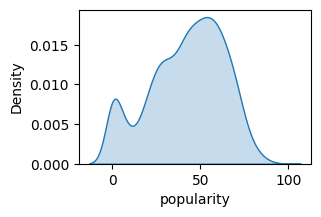

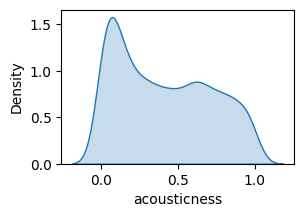

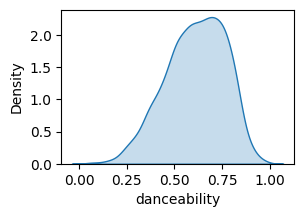

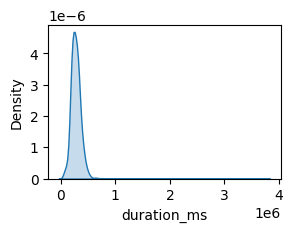

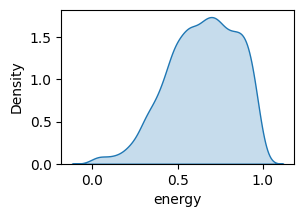

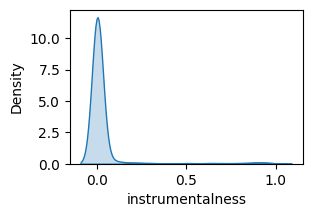

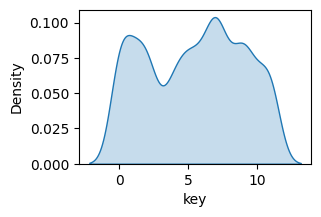

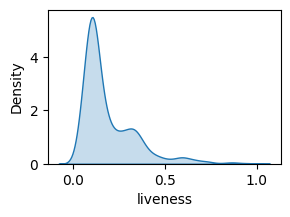

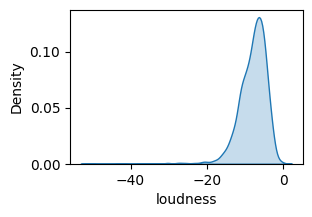

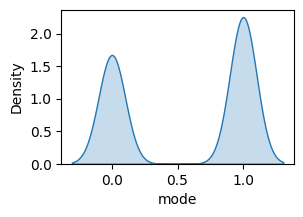

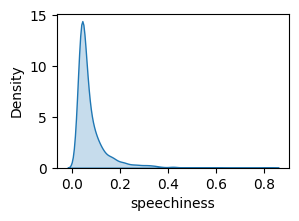

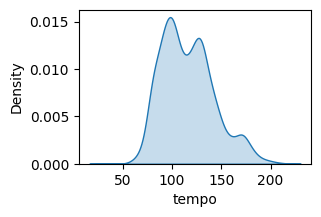

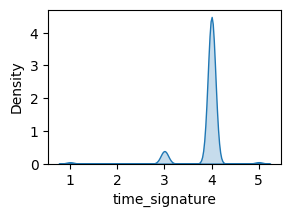

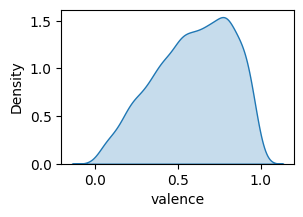

In [ ]:
for column in df.columns:
  if df[column].dtype == "float64":
    plt.figure(figsize=(3, 2))
    sns.kdeplot(data=df, x=column, fill=True)
    plt.show()

<Axes: ylabel='release_date'>

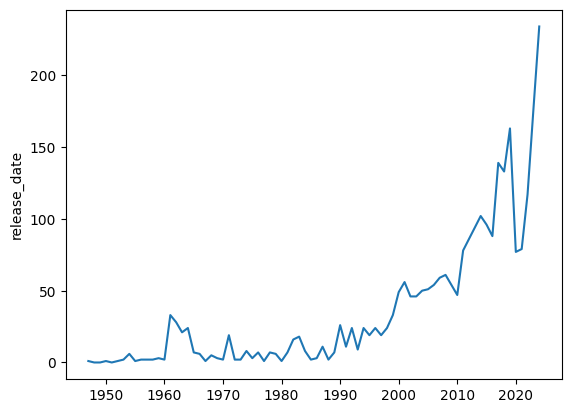

In [ ]:
df1 = df.release_date.value_counts()
df1.sort_index(ascending=True, inplace=True)
df1 = df1.resample('Y').sum()

sns.lineplot(df1)

In [ ]:
df.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,2731.000000,2731.000000,2731.000000,2.731000e+03,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000
mean,42.213109,0.409857,0.609096,2.752726e+05,0.645563,0.036268,5.436836,0.192282,-8.127544,0.574149,0.077037,115.801234,3.905895,0.591235
std,21.004308,0.304208,0.156330,1.160792e+05,0.200909,0.151230,3.505300,0.149896,3.835586,0.494562,0.070733,26.758399,0.391679,0.231852
min,0.000000,0.000021,0.058600,3.336100e+04,0.002780,0.000000,0.000000,0.014700,-50.700000,0.000000,0.023200,32.755000,1.000000,0.000010
25%,28.000000,0.120000,0.503000,2.128105e+05,0.505000,0.000000,2.000000,0.096600,-9.993000,0.000000,0.037200,95.008500,4.000000,0.419000
50%,45.000000,0.367000,0.622000,2.652830e+05,0.662000,0.000012,6.000000,0.131000,-7.499000,1.000000,0.050900,112.619000,4.000000,0.614000
75%,58.000000,0.666000,0.732500,3.247020e+05,0.808500,0.000526,8.000000,0.262000,-5.595000,1.000000,0.086700,131.979500,4.000000,0.783000
max,94.000000,0.996000,0.974000,3.764323e+06,0.996000,0.999000,11.000000,0.979000,-0.133000,1.000000,0.819000,214.016000,5.000000,0.994000


In [ ]:
df.reset_index(inplace=True)

df.drop('index', axis=1, inplace=True)

In [ ]:
df.to_csv("tracks_info_cleaned.csv", index=False)

#**BUILDING RECOMMENDATION MODEL USING CONTENT BASED FILTERING**

In [ ]:
pip install spotipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import auth
from google.cloud import bigquery

In [ ]:
auth.authenticate_user()

from google.cloud import bigquery

client = bigquery.Client(project='XXXXXXXXXXXXXXX')

query = "SELECT * FROM `XXXXXXXXXXXXXXX.XXXXXXXXXXXXXXX.XXXXXXXXXXXXXXXl`"

query_job = client.query(query)

results = query_job.result()

df = results.to_dataframe()
pd.set_option('display.max_colwidth', None)

features_column = []
for column in df.columns:
  if df[column].dtype == "float64":
    features_column.append(column)

features_column = features_column[1:]

In [ ]:
def get_recommendations(song_id, k=10):

    try:
        user_song = df[df["track_id"] == song_id][["track_name", "artist_name", "album_name"]]
        print(f"Since, You liked {user_song.track_name.values[0]} by artist {user_song.artist_name.values[0]} from album {user_song.album_name.values[0]}")
        print("")
        print("You might like these songs too:")
        print("")

        # Normalize the audio features (optional but recommended)
        scaler = MinMaxScaler()
        normalized_features = scaler.fit_transform(df[features_column])


        # # Compute the cosine similarity matrix
        cosine_sim = cosine_similarity(normalized_features, normalized_features)

        song_index = df[df.track_id==song_id].index[0]

        sim_scores = list(enumerate(cosine_sim[song_index]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        top_songs = sim_scores[1:k+1]
        recommended_songs = [song for song, _ in top_songs]
        
        final = df[df.index.isin(recommended_songs)][["track_name", "artist_name", "album_name", "song_url"]]
        final = final.reset_index(drop=True)
        final.index = range(1, len(final) + 1)
        return final

    except:
        print("Sorry, This song is not available in our database")

def search(song):
  results = sp.search(q=song, type='track', limit=1)
  if len(results['tracks']['items']) > 0:
      track = results['tracks']['items'][0]
      track_name = track['name']

      track_id = track['id']
      if track_id not in df.track_id.values:

        track_name = track['name']
        artist_name = track['artists'][0]['name']
        album_name = track['album']['name']
        track_id = track['id']
        preview_url = track['preview_url']
        popularity = track['popularity']
        release_date = track['album']['release_date']
        song_url = track['external_urls']['spotify']

        artist_id = track['artists'][0]['id']
        artist = sp.artist(artist_id)
        genres = artist['genres']

        audio_features = sp.audio_features([track_id])[0]

        def check_na(feature):
          try:
            feature = audio_features[f"{feature}"]
          except:
            feature = "NA"
        
          return feature
            
        acousticness = check_na("acousticness")
        danceability = check_na("danceability")
        duration_ms = check_na('duration_ms')
        energy = check_na('energy')
        instrumentalness = check_na('instrumentalness')
        key = check_na('key')
        liveness = check_na('liveness')
        loudness = check_na('loudness')
        mode = check_na('mode')
        speechiness = check_na('speechiness')
        tempo = check_na('tempo')
        time_signature = check_na('time_signature')
        valence = check_na('valence')
        
        new_song = [track_name, artist_name, album_name, track_id, preview_url, popularity, release_date, song_url, genres, acousticness, danceability, 
                        duration_ms, energy, instrumentalness, key, liveness, loudness, mode, speechiness, tempo, time_signature,
                        valence]
        
        df.loc[len(df)] = new_song

        return get_recommendations(track_id)

      else:
        return get_recommendations(track_id)

In [ ]:
user_input = input("Song Name: ")
print("")
#spotify api
search(user_input.title())

Song Name: all i need by prateek

Since, You liked All I Need by artist Prateek Kuhad from album The Way That Lovers Do

You might like these songs too:



,track_name,artist_name,album_name,song_url
1,Khuda Bhi Aasman - Recorded at Spotify Studios NYC,Khruangbin,Spotify Singles,https://open.spotify.com/track/5lZX0cZpdT3Y10uJ3oR17s
2,FF4,Flying Lotus,Flamagra,https://open.spotify.com/track/39nSL4qbk0rsGNSVJb5TWK
3,Zara Nazron Se Kah Do Ji,Hemant Kumar,Bees Saal Baad,https://open.spotify.com/track/19fiFB1xLiWTMipje2Gx6T
4,Main Jahaan Rahoon - Instrumental,Naveen Kumar,Melodies of Love,https://open.spotify.com/track/2nmfekXkcyd0w92dY2Lrwp
5,O Mere Majhi Mere Sajan Hai,S. D. Burman,Bandini,https://open.spotify.com/track/4uGPqOjuGa9pqRDFAAPhAC
6,Tu Na Ja Mere Badshah Tum ho,Makhdoom Raja,Gujjar Wapis Agya,https://open.spotify.com/track/08sXngomA2CIZlyF7Ayt5Y
7,Jane Kya Dhoondti Rahti Hai,Mohammed Rafi,Shola Aur Shabnam,https://open.spotify.com/track/2s6EhBmaws10JwByVGRWeC
8,Yeh Mera Prem Patra,Mohammed Rafi,Sangam,https://open.spotify.com/track/6v9g8NkqeQZa73MQkPnlFa
9,Bahara - Chill Version - Instrumental,Vishal-Shekhar,Sounds of Love,https://open.spotify.com/track/7tybTSsY7m6aoTOd01WsyI
10,Dam Bhar Jo Udhar Munh Phere,Lata Mangeshkar,Awara,https://open.spotify.com/track/4saThgeq3MOUI8cUmZBYqs


#**BUILDING RECOMMENDATION MODEL USING KNN**



In [ ]:
x = df[audio_features].values


k = 11
knn_model = NearestNeighbors(n_neighbors=k, metric='euclidean')
knn_model.fit(x)

NearestNeighbors(metric='euclidean', n_neighbors=11)

In [ ]:
df1 =df
df1.reset_index(drop=True, inplace=True)

def recommend(song):
  results = sp.search(q=song, type='track', limit=1)
  if len(results['tracks']['items']) > 0:
      track = results['tracks']['items'][0]

      track_name = track['name']
      artist_name = track['artists'][0]['name']
      album_name = track['album']['name']
      track_id = track['id']
      preview_url = track['preview_url']
      popularity = track['popularity']
      release_date = track['album']['release_date']
      song_url = track['external_urls']['spotify']
      
      audio_features = sp.audio_features([track_id])[0]

      def check_na(feature):
        try:
          feature = audio_features[f"{feature}"]
        except:
          feature = "NA"
        
        return feature
          
      acousticness = check_na("acousticness")
      danceability = check_na("danceability")
      duration_ms = check_na('duration_ms')
      energy = check_na('energy')
      instrumentalness = check_na('instrumentalness')
      key = check_na('key')
      liveness = check_na('liveness')
      loudness = check_na('loudness')
      mode = check_na('mode')
      speechiness = check_na('speechiness')
      tempo = check_na('tempo')
      time_signature = check_na('time_signature')
      valence = check_na('valence')
      
      features = np.array([acousticness, danceability, 
                      duration_ms, energy, instrumentalness, key, liveness, loudness, mode, speechiness, tempo, time_signature,
                      valence]) 

      dist, indices = knn_model.kneighbors(features.reshape(-1, 13))

      song_list = []
      album_list = []
      artist_list = []
      serial = [i for i in range(1, 12)]

      for i in indices:
        song_name = df1.iloc[i].track_name
        album_name = df1.iloc[i].album_name
        artist_name = df1.iloc[i].artist_name
        song_list.append(song_name)
        album_list.append(album_name)
        artist_list.append(artist_name)

      temp = pd.DataFrame()
      temp["Recommended Songs"] = song_list[0]
      temp["Artist"] = artist_list[0]
      temp["Album"] = album_list[0]
      temp["Serial No."] = serial
      temp = temp.set_index("Serial No.")
      return temp[1:]

  else:
      print("No matching tracks found.")

In [6]:
user_input = input("Song Name: ")
print(f"Since, You liked {user_input}, You might like these songs too")
recommend(user_input)